<a href="https://colab.research.google.com/github/yovelop/NN/blob/master/NN_Energy_Predictor_0.31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DIR = '/content/drive/My Drive/Colab Notebooks/ENSaver/'
DIR_SAVE = '/content/drive/My Drive/Colab Notebooks/ENSaver/31/'
#drive.flush_and_unmount()

In [0]:
#Импорты
  import numpy as np # linear algebra
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
  import gc

  import matplotlib.pyplot as plt
  import matplotlib.style
  matplotlib.style.use('ggplot')

  from sys import getsizeof

  import os
  for dirname, _, filenames in os.walk(DIR):
      for filename in filenames:
          print(os.path.join(dirname, filename))

  pd.options.mode.chained_assignment = None  # default='warn'
  import warnings
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 100)
  warnings.filterwarnings('ignore')
  np.set_printoptions(precision = 3, suppress  = True)
  pd.set_option('display.float_format', lambda x: '%.3f' % x)

  def reduce_mem_usage(df, verbose = False):
      start_mem_usg = df.memory_usage().sum() / 1024**2 
      print("Memory usage of properties dataframe is :",start_mem_usg," MB")
      NAlist = [] # Keeps track of columns that have missing values filled in. 
      for col in df.columns:
          if (df[col].dtype != object) &  (df[col].dtype != 'datetime64[ns]'):  # Exclude strings            
              # Print current column type
              if verbose:  
                print("******************************")
                print("Column: ",col)
                print("dtype before: ",df[col].dtype)            
              # make variables for Int, max and min
              IsInt = False
              mx = df[col].max()
              mn = df[col].min()
              if verbose:
                print("min for this col: ",mn)
                print("max for this col: ",mx)
              # Integer does not support NA, therefore, NA needs to be filled
              if not np.isfinite(df[col]).all(): 
                  NAlist.append(col)
                  df[col].fillna(mn-1,inplace=True)  
                    
              # test if column can be converted to an integer
              asint = df[col].fillna(0).astype(np.int64)
              result = abs(df[col] - asint)
              result = result.sum()
              if result > -0.01 and result < 0.01:
                  IsInt = True            
              # Make Integer/unsigned Integer datatypes
              if IsInt:
                  if mn >= 0:
                      if mx < 255:
                          df[col] = df[col].astype(np.uint8)
                      elif mx < 65535:
                          df[col] = df[col].astype(np.uint16)
                      elif mx < 4294967295:
                          df[col] = df[col].astype(np.uint32)
                      else:
                          df[col] = df[col].astype(np.uint64)
                  else:
                      if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                          df[col] = df[col].astype(np.int8)
                      elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                          df[col] = df[col].astype(np.int16)
                      elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                          df[col] = df[col].astype(np.int32)
                      elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                          df[col] = df[col].astype(np.int64)    
              # Make float datatypes 32 bit
              else:
                  df[col] = df[col].astype(np.float32)
              
              # Print new column type
              if verbose:
                print("dtype after: ",df[col].dtype)
                print("******************************")
      # Print final result
      print("___MEMORY USAGE AFTER COMPLETION:___")
      mem_usg = df.memory_usage().sum() / 1024**2 
      print("Memory usage is: ",mem_usg," MB")
      print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
      return df, NAlist

  def show_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()
    
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1,2])
    plt.legend(['Train','Val'])
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0,1])
    plt.legend(['Train','Val'])
    plt.show()

  #Импорты Керас:
  from keras.models import Sequential, load_model

  from keras.layers import Dense, Dropout
  from keras.initializers import TruncatedNormal, Constant
  from keras.regularizers import l1,l2,l1_l2
  from keras.optimizers import Adam
  import keras.backend as K

  from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
  #from keras.utils import plot_model
  from keras.losses import mean_squared_error as mse #, mean_absolute_percentage_error as mape

  def RMSLE(y_true, y_pred):
    return K.pow( K.mean( K.pow(K.log(y_true+1) - K.log(y_pred+1),2.00000)),0.5000)

  def MSLE(y_true, y_pred):
    return K.mean( K.pow(K.log(y_true+1) - K.log(y_pred+1),2.00000))

  def MALE(y_true, y_pred):
    return K.mean( K.abs(K.log(y_true+1) - K.log(y_pred+1)))

  def tweedieloss(y_true, y_pred):
      return K.mean(  K.pow(    K.pow(backend.maximum(0.000,K.maximum(0.013000,y_true)),0.5)  -   K.pow(K.maximum(0.013000,y_pred),0.5)   , 2 ) / K.pow(K.maximum(0.013000,y_pred),0.5)
                  )

  def tweedieloss_bkp(y_true, y_pred):
      p=1.5
      dev = 2 * (K.pow(K.maximum(0.000,y_true), 2-p)/((1-p) * (2-p)) -
                    y_true * K.pow(y_pred, 1-p)/(1-p) +
                    K.pow(y_pred, 2-p)/(2-p))
      return K.mean(dev)

  def VAL_ (y_true, y_pred):
      return  K.maximum(0.0330000, K.sum(y_pred))/ K.maximum(0.033000, K.sum(y_true)) 
      
  def VAL_2 (y_true, y_pred):
      return  K.minimum( 5.000000, K.exp ( K.abs( K.log( VAL_ (y_true, y_pred))))-1)
  
  def VAL_3 (y_true, y_pred):
      return  K.exp ( K.abs( K.log( VAL_ (y_true, y_pred))))-1

  def MAPE_ (y_true, y_pred):
      return K.mean( K.minimum( 5.000000,  K.abs(y_true - y_pred)/ K.maximum(0.033000, y_true)) )
      
  def MAE_(y_true, y_pred):
      return K.sum( K.abs(y_true - y_pred))/ K.maximum(0.033000, K.sum(y_true))

  def MSE_(y_true, y_pred):
      return K.sum( K.pow(y_true - y_pred,2.00000))/ K.maximum(0.033000,  K.sum(K.pow(y_true,2.00000)))

  def MAE_MAPE(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          +  0.250000 * MAPE_ (y_true, y_pred)
      )
              
  def MAE_VAL_MAPE(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          + 1.800000 *   VAL_2 (y_true, y_pred)          
          + 0.950000 *   MAPE_ (y_true, y_pred)
          )

  def MAE_VAL(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          + 0.800000 *   VAL_2 (y_true, y_pred)                     
              )

  def MAPE_VAL(y_true, y_pred):
      return (
                      MAPE_ (y_true, y_pred)
          + 0.4000 *  VAL_2 (y_true, y_pred)             
              )

  def MSE_VAL_MAPE(y_true, y_pred):
      return (
            5.000000 *   MSE_(y_true, y_pred)
          + 2.200000 *   VAL_2 (y_true, y_pred)          
          + 0.750000 *   MAPE_ (y_true, y_pred)
          )

  def MASPE_VAL(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)               
          + 0.500000 *   MSE_(y_true, y_pred)
          + 1.200000 *   VAL_2 (y_true, y_pred)          
          + 0.250000 *   MAPE_ (y_true, y_pred)
          )
  
  def MAE_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAE_   (y_true, y_pred)
          + 2.000000 *   MSLE  (y_true, y_pred)          
          )  

  def MAPE_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAPE_   (y_true, y_pred)
          + 0.100000 *   MSLE  (y_true, y_pred)          
          )  
  
  def MAPE_VAL_RMSLE(y_true, y_pred):
      return (
            0.500000 *   MAPE_   (y_true, y_pred)
          + 1.500000 *   MSLE   (y_true, y_pred)    
          + 0.300000 *   VAL_2   (y_true, y_pred)      
          )  
 
  import keras.metrics
  keras.metrics.MAE_ = MAE_
  keras.metrics.VAL_ = VAL_
  keras.metrics.VAL_2 = VAL_2
  keras.metrics.MAPE_ = MAPE_
  keras.metrics.MSE_ = MSE_
  keras.metrics.tweedieloss = tweedieloss
  keras.metrics.MAE_RMSLE = MAE_RMSLE
  keras.metrics.MAPE_RMSLE = MAPE_RMSLE
  keras.metrics.MAPE_VAL_RMSLE = MAPE_VAL_RMSLE
  keras.metrics.RMSLE = RMSLE
  keras.metrics.MSLE = MSLE
  keras.metrics.MALE = MALE

  import keras.losses
  keras.losses.MAE_VAL_MAPE = MAE_VAL_MAPE
  keras.losses.MSE_VAL_MAPE = MSE_VAL_MAPE
  keras.losses.MAE_ = MAE_
  keras.losses.MASPE_VAL = MASPE_VAL
  keras.losses.tweedieloss = tweedieloss
  keras.losses.MAE_RMSLE = MAE_RMSLE
  keras.losses.MAPE_RMSLE = MAPE_RMSLE
  keras.losses.MAPE_VAL_RMSLE = MAPE_VAL_RMSLE
  keras.losses.RMSLE = RMSLE
  keras.losses.MSLE = MSLE
  keras.losses.MALE = MALE

  class MyCustomCallback(keras.callbacks.Callback):
    
    def __init__(self, epochs, stats_print_step): 
        
        self.__epochs = epochs
        self.__stats_print_step = stats_print_step
    
    def on_train_begin(self, logs={}):
        pass
        #print('on_train_begin', logs)
 
    def on_train_end(self, logs={}):
        pass
        #print('on_train_end', logs)
 
    def on_epoch_begin(self, epoch, logs={}):
        pass
 
    def on_epoch_end(self, epoch, logs={}):
        if ((epoch < 5) or (epoch % self.__stats_print_step == 0)) :
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs))
        if epoch == 2:
            print('.......')
        if epoch == self.__epochs - 1:
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs))
        else:
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs), end="\r")
 
    def on_batch_begin(self, batch, logs={}):
        pass
        #print('on_batch_begin', batch, logs)
 
    def on_batch_end(self, batch, logs={}):
        pass
        #print('on_batch_end', batch, logs)

    def get_stats_by_epoch(self, logs):
        
        is_test = True
        s = ''
        
        for key, value in logs.items(): 
            if is_test:
                if 'val_' not in str(key):
                    s += ' /// '
                    is_test = False
            if is_test:
                s += ' ' + str(key).replace('val_', 'TST_') + ': ' + "{0:.4f}".format(value)
            else:
                s += ' ' + 'TRN_' + str(key) + ': ' + "{0:.4f}".format(value)

        return s #'val_loss: ' + "{0:.4f}".format(logs['val_loss']) + ' | loss: ' + "{0:.4f}".format(logs['loss'])

In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
#  Подготовка данных
  df = pd.read_csv(DIR + "train.csv", engine = 'python')
  df['timestamp'] = pd.to_datetime(df['timestamp'])

  df['hour_cos'] = np.cos(df['timestamp'].dt.hour * 2 * np.pi / 24)
  df['hour_sin'] = np.sin(df['timestamp'].dt.hour * 2 * np.pi / 24)

  df['weekday_cos'] = np.cos(df['timestamp'].dt.weekday * 2 * np.pi / 7)
  df['weekday_sin'] = np.sin(df['timestamp'].dt.weekday * 2 * np.pi / 7)

  df['week_cos'] = np.cos(df['timestamp'].dt.week * 2 * np.pi / 53)
  df['week_sin'] = np.sin(df['timestamp'].dt.week * 2 * np.pi / 53)

In [0]:
#Очистка от подозрительных нулей
  #print(df[df['building_id']==2][['timestamp','meter_reading','meter','ds_zero','de_zero','is_bad_zero']].head(20))
  df = df.sort_values(by = ['meter','building_id','timestamp'])
  df['meter_reading_prev'] = 0

  #for bid in df['building_id'].unique():
  #  for met in df['meter'].unique():
  df['meter_reading_prev'] = df['meter_reading'].shift()
  df['is_equal_prev']= (df['meter_reading_prev'] == df['meter_reading'] )*1

  df['day'] = df['timestamp'].dt.dayofyear
  df_bad_rows = df.groupby(by=['building_id','day','meter'], as_index = False)['is_equal_prev'].mean()
  df_bad_rows.rename({"is_equal_prev": "IS_BAD_PRCNT"}, axis='columns', inplace=True)

  df = pd.merge(df, df_bad_rows, how = 'inner', on = ['building_id','day','meter'])
  #print(df_bad_rows[df_bad_rows['building_id']==109].head(365))
  del df_bad_rows 

  #print(df[df['building_id']==2][['timestamp','meter_reading','is_equal_prev','IS_BAD_PRCNT','day']].head(30))
# Добавление медиан
  # Добавление медианы по метрике постройки
  if 1==1:
    #df_tmp = df[df['IS_BAD_PRCNT']<0.45]
    df_median = df.groupby(by=['building_id','meter']) ['meter_reading'].median()
    df_median.name = 'building_meter_median'
    df_mean = df.groupby(by=['building_id','meter']) ['meter_reading'].mean()
    df_mean.name = 'building_meter_mean'
    df_median = pd.merge(df_median, df_mean, how = 'inner', on = ['building_id','meter'])
    df_median['building_meter_median'] = ( df_median['building_meter_median'] * 27.000 + df_median['building_meter_mean'])/28.000
    
    df_median2 = df[df['IS_BAD_PRCNT']<0.45].groupby(by=['building_id','meter']) ['meter_reading'].median()
    df_median2.name = 'building_meter_median_45'
    df_mean2 = df[df['IS_BAD_PRCNT']<0.45].groupby(by=['building_id','meter']) ['meter_reading'].mean()
    df_mean2.name = 'building_meter_mean_45'
    df_median2 = pd.merge(df_median2, df_mean2, how = 'inner', on = ['building_id','meter'])
    df_median2['building_meter_median_45'] = ( df_median2['building_meter_median_45'] * 27.000 + df_median2['building_meter_mean_45'])/28.000
    df_median = pd.merge(df_median, df_median2, how = 'left', on = ['building_id','meter'])

    df_median['building_meter_median'] = np.where(df_median['building_meter_median_45'] >= 0, df_median['building_meter_median_45'], df_median['building_meter_median'])
    df_median.drop(columns=['building_meter_median_45'], inplace = True)

    df = pd.merge(df, df_median, how = 'inner', on = ['building_id','meter'])
    del df_median , df_mean, df_median2, df_mean2
    gc.collect()
    #print(len(df))
  # Добавление медианы по часу, по неделе, метрике постройки
  if 1==1:
    df['hour'] = df['timestamp'].dt.hour
    df_median = df.groupby(by=['building_id','hour','meter'])['meter_reading'].median()
    df_median.name = 'building_meter_hour_median'
    df_mean = df.groupby (by=['building_id','hour','meter']) ['meter_reading'].mean()
    df_mean.name = 'building_meter_hour_mean'
    df_median = pd.merge(df_median, df_mean, how = 'inner', on = ['building_id','hour','meter'])
    df_median['building_meter_hour_median'] = (df_median['building_meter_hour_median'] * 9.000000 + df_median['building_meter_hour_mean'])/10.000000
    #print(len(df))

    df_median2 = df[df['IS_BAD_PRCNT']<0.75].groupby(by=['building_id','hour','meter'])['meter_reading'].median()
    df_median2.name = 'building_meter_hour_median_all'
    df_mean2 = df[df['IS_BAD_PRCNT']<0.75].groupby (by=['building_id','hour','meter']) ['meter_reading'].mean()
    df_mean2.name = 'building_meter_hour_mean_all'
    df_median2 = pd.merge(df_median2, df_mean2, how = 'inner', on = ['building_id','hour','meter'])
    df_median2['building_meter_hour_median_all'] = (df_median2['building_meter_hour_median_all'] * 9.000000 + df_median2['building_meter_hour_mean_all'])/10.000000
    df_median2.drop(columns=['building_meter_hour_mean_all'], inplace = True)
    df_median = pd.merge(df_median, df_median2, how = 'left', on = ['building_id','hour','meter'])
    
    df_median['building_meter_hour_median'] = np.where(df_median['building_meter_hour_median_all'] >= 0, df_median['building_meter_hour_median_all'], df_median['building_meter_hour_median'])
    #print(len(df))

    df_median.drop(columns=['building_meter_hour_median_all'], inplace = True)
    df_median2 = df[df['IS_BAD_PRCNT']<0.45].groupby(by=['building_id','hour','meter'])['meter_reading'].median()
    df_median2.name = 'building_meter_hour_median_45'
    df_mean2 = df[df['IS_BAD_PRCNT']<0.45].groupby (by=['building_id','hour','meter']) ['meter_reading'].mean()
    df_mean2.name = 'building_meter_hour_mean_45'
    df_median2 = pd.merge(df_median2, df_mean2, how = 'inner', on = ['building_id','hour','meter'])
    df_median2['building_meter_hour_median_45'] = (df_median2['building_meter_hour_median_45'] * 9.000000 + df_median2['building_meter_hour_mean_45'])/10.000000
    df_median2.drop(columns=['building_meter_hour_mean_45'], inplace = True)
    df_median = pd.merge(df_median, df_median2, how = 'left', on = ['building_id','hour','meter'])
    
    df_median['building_meter_hour_median'] = np.where(df_median['building_meter_hour_median_45'] >= 0, df_median['building_meter_hour_median_45'], df_median['building_meter_hour_median'])
    df_median.drop(columns=['building_meter_hour_median_45'], inplace = True)

    df = pd.merge(df, df_median, how = 'left', on = ['building_id','hour','meter'])
    #print(len(df))

    del df_median , df_mean, df_median2, df_mean2
    gc.collect()
    df['k_fact_med_hour']=np.exp( np.abs( np.log( (df['meter_reading']+0.01)/(df['building_meter_hour_median']+0.01)) ) )

    df['weekday'] = df['timestamp'].dt.weekday
    df_median = df.groupby(by=['building_id','weekday','meter'])['meter_reading'].median()
    df_median.name = 'building_meter_weekday_median'
    df = pd.merge(df, df_median, how = 'inner', on = ['building_id','weekday','meter'])
    del df_median 

    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                      "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                      "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                      "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                      "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                      "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                      "2019-01-01"]
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
    del holidays
    #print(len(df))
  # Подстановка параметров сооружения
  if 1==1:
    building_df = pd.read_csv(DIR + "building_metadata.csv", engine = 'python')
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    building_df["primary_use_ID"] = le.fit_transform(building_df["primary_use"])
    #building_df['floor_count'].fillna(building_df['floor_count'].mean(), inplace= True)
    #building_df['year_built'].fillna(building_df['year_built'].mean, inplace= True)
    #building_df['primary_use'] = building_df['primary_use'].astype('category')
    #building_df = pd.get_dummies(building_df)

    df = df.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
    df.head(5)
    del building_df
    gc.collect()

    # Деление по магазинам на обучающую и тестовую выборки
      # building_df = pd.read_csv(DIR + "building_metadata.csv", engine = 'python')
      # building_df = building_df.sort_values(by = ['site_id','primary_use'])
      # building_df['is_val'] = np.where(building_df['building_id'] % 5 == 0 , 1 , 0)
      # print(building_df.groupby(['primary_use','site_id'])['is_val'].agg(['count', 'sum']))

In [5]:
#Вставка данных погоды
#Восстановление пустых данных погоды через соседей по линейной инетрполяции
  df_weather = pd.read_csv(DIR + "weather_train.csv", engine = 'python')
  df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

  #weather_train.groupby('site_id').apply(lambda group: group.isna().sum())
  df_times = df.drop_duplicates(['site_id','timestamp'])[['site_id','timestamp']]
  df_times = pd.merge(df_times, df_weather, how = 'left', on = ['site_id','timestamp'])
  df_times = df_times.sort_values(by = ['site_id','timestamp'])
  
  df_times = df_times.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
  df_times = df_times.groupby('timestamp').apply(lambda group: group.interpolate(limit_direction='both'))
  df = pd.merge(df, df_times, how = 'left', on = ['site_id','timestamp'])
  #print(df_times.describe())
  del df_weather, df_times
  gc.collect()

0

In [0]:
#Сохранение выборки
  #reduce_mem_usage(df)
  df.to_feather(DIR_SAVE + 'DF_TRAIN_REDUCED3.FTHR')

  Скорость

In [0]:
# Загрузка выборки
  df = pd.read_feather(DIR_SAVE + 'DF_TRAIN_REDUCED3.FTHR')
  gc.collect()

In [0]:
Out_Columns = 'meter_reading'
In_Columns = [ 'hour_cos','hour_sin', 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin',
       'site_id', 'square_feet',
       'primary_use_ID', 'is_holiday',
       'air_temperature', 'cloud_coverage',
       'dew_temperature', 'sea_level_pressure',
       'wind_direction', 'wind_speed',
       'building_meter_median','building_meter_hour_median','building_meter_weekday_median',
       #КАНДИДАТЫ нА ИСКЛЮЧЕНИЕ:
          #'year_built', 'floor_count', 'precip_depth_1_hr',
          #  'primary_use_Education', 'primary_use_Entertainment/public assembly', 'primary_use_Food sales and service', 'primary_use_Healthcare',
          #  'primary_use_Lodging/residential','primary_use_Manufacturing/industrial', 'primary_use_Office',
          #  'primary_use_Other', 'primary_use_Parking', 'primary_use_Public services', 'primary_use_Religious worship',
          #  'primary_use_Retail', 'primary_use_Services', 'primary_use_Technology/science', 'primary_use_Utility','primary_use_Warehouse/storage',
       ]
# Нормализация
if 1==1:
  df.dropna(subset = In_Columns + [Out_Columns], inplace=True)

  #print(df[['air_temperature', 'cloud_coverage','dew_temperature', 'sea_level_pressure','wind_direction', 'wind_speed']].describe())
  from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
  scaler =  MinMaxScaler (copy=True, feature_range=(0, 1))                                  #quantile_range  = (15.0,85.0)) #Normalizer #(copy=True, feature_range=(-1, 1)) # MinMaxScaler(copy=True, feature_range=(-1, 1)) #StandardScaler() #MinMaxScaler(copy=True, feature_range=(-1, 1)) # RobustScaler()
  scaler.fit( df[In_Columns] )
  df[In_Columns]     = pd.DataFrame(data = scaler.transform( df[In_Columns]) , columns = df[In_Columns].columns   ) 
  gc.collect()

  #print(df[['air_temperature', 'cloud_coverage','dew_temperature', 'sea_level_pressure','wind_direction', 'wind_speed']].describe())

  import pickle
  with open(DIR_SAVE+'scaler31.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(In_Columns, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(Out_Columns, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
  #with open('filename.pickle', 'rb') as handle:
  #  b = pickle.load(handle)

In [0]:
#Всякое инфо:
  #df[['building_id','hour','meter','building_meter_hour_mean','building_meter_hour_median','meter_reading','k_fact_med_hour']].head(10)
  #Инфо о корявости данных:
  if 1== 1:
    print('0 Всего:',df[df['meter']==0].shape, 'Откинуть:', df[(df['meter']==0) & (df['IS_BAD_PRCNT']>0.45)].shape)
    print('1 Всего:',df[df['meter']==1].shape, 'Откинуть:', df[(df['meter']==1) & (df['IS_BAD_PRCNT']>0.75)].shape)
    print('2 Всего:',df[df['meter']==2].shape, 'Откинуть:', df[(df['meter']==2) & (df['IS_BAD_PRCNT']>0.75)].shape)
    print('3 Всего:',df[df['meter']==3].shape, 'Откинуть:', df[(df['meter']==3) & (df['IS_BAD_PRCNT']>0.75)].shape)
    # #Вывести кол-во пустот по полям. Затем заполнить из средним значением по полю
    #   for col in df.columns:
    #     print(col)
    #     for met in df['meter'].unique():
    #       if np.sum(df[col].isnull()) > 0:
    #         print(met)
    #         print(np.sum(df[col].isnull()))

    #         df_col = df.groupby(by=['building_id','meter'], as_index = False)[col].mean()
    #         df_col.rename({col: "tmp"}, axis='columns', inplace=True)
    #         df = df.merge(df_col, left_on = ['building_id','meter'], right_on = ['building_id','meter'], how = "left")
    #         df[col].fillna( df_col['tmp'], inplace = True)
    #         df.drop(columns = ['tmp'],inplace = True)
    #         del df_col

    #         df_col = df.groupby(by=['meter'], as_index = False)[col].mean()
    #         df_col.rename({col: "tmp"}, axis='columns', inplace=True)
    #         df = df.merge(df_col, left_on = ['meter'], right_on = ['meter'], how = "left")
    #         df[col].fillna( df_col['tmp'], inplace = True)
    #         df.drop(columns = ['tmp'],inplace = True)
    #         del df_col

    #         df[col].fillna( df[col].mean(), inplace = True)

  print(len(df[df['IS_BAD_PRCNT']<0.45]), len(df))

**-- -- -- -- -- -- -- -- --РАСЧЁТ НЕЙРОНОК -- -- -- -- -- -- -- -- --**

In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
# РАСЧЁТ НЕЙРОНОК:
  reg = 0.00001
  batch_size = 2048
  epochs = 12
  meter = 0

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=7, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  init = TruncatedNormal(mean=0.0, stddev=0.05, seed=159)
  bias = Constant(value = 1e-3)
  
  if 0==0:
    meter = 0
    opt = Adam(lr = 0.0009)
    bias = Constant(value = 0.1)

    nn_0 = Sequential()
    nn_0.add(Dense(60, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l2(reg), kernel_initializer = 'normal'))
    nn_0.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal'))
    nn_0.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal', kernel_regularizer=l1(reg)))
    nn_0.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal'))
    nn_0.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_0.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    
    val = df[(df['meter']==meter) & (df['day']%6==0)]
    hist = nn_0.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 0
                    , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 
    nn_0.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
    gc.collect()

In [0]:
# Дообучение!
  meter = 0
  nn_tmp = keras.models.load_model (DIR_SAVE + str(meter) + 'HANDLY_SAVED3best.MODEL')
  
  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=7, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  for lr in [0.007]:
    opt = Adam(lr = lr)
    epochs = 20
    batch_size = 2048
    
    val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < 0.25 ) ]
    tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < 0.25 ) ]

    print('*'*9, lr, '*'*33)
    nn_tmp.compile(optimizer = opt, loss = MSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    hist = nn_tmp.fit( tar[In_Columns], tar[Out_Columns], batch_size = batch_size, verbose = 0
                    , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                  )
    
    nn_tmp.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
    del val, tar
    gc.collect()

In [0]:
#История ошибок:
    # 0 - 0.0009|  TST_loss: 0.3072 TST_MAE_: 0.1830 TST_RMSLE: 0.2885 TST_VAL_: 0.9286 TST_mean_squared_error: 27367.7978 TST_MAPE_: 0.2095 ///  TRN_loss: 0.3087 TRN_MAE_: 0.1822 TRN_RMSLE: 0.2900 TRN_VAL_: 0.9145 TRN_mean_squared_error: 28093.1744 TRN_MAPE_: 0.2099
    #Ошибка 0:  1.0561841191435806 Ошибка 0 (VAL):  1.0494709359899506 Ошибка 0 (VAL_чист):  0.3156408787681845 Ошибка 0 (VAL_чист):  0.2912135296204619
    #Ошибка 0:  1.089517078219136  Ошибка 0 (VAL):  1.0830665788767133 Ошибка 0 (VAL_чист):  0.32307141312090654 Ошибка 0 (VAL_чист):  0.2984998363948374
      #Ошибка 0:  1.1066134245452997 Ошибка 0 (VAL):  1.100076285523506  Ошибка 0 (VAL_чист):  0.3034311145371631  Ошибка 0 (VAL_чист):  0.2775469766783069
      #Ошибка 0:  1.1030193587492334 Ошибка 0 (VAL):  1.0966634328629619 Ошибка 0 (VAL_чист):  0.31766628931864216 Ошибка 0 (VAL_чист):  0.2947707690483286
      #Ошибка 0:  1.11466815037453   Ошибка 0 (VAL):  1.1077580860952245 Ошибка 0 (VAL_чист):  0.36128705026829394 Ошибка 0 (VAL_чист):  0.3413465001124272
      #Ошибка 0:  1.1159494605817608 Ошибка 0 (VAL):  1.108724065391442  Ошибка 0 (VAL_чист):  0.41233170157550914 Ошибка 0 (VAL_чист):  0.39348967701947696
      #Ошибка 0:  1.1161679797276878 Ошибка 0 (VAL):  1.1092097596156938 Ошибка 0 (VAL_чист):  0.44160974266951963 Ошибка 0 (VAL_чист):  0.42010303885086286

    # 1 - 0.0005|  TST_loss: 0.8377 TST_MAE_: 0.3466 TST_RMSLE: 0.8257 TST_VAL_: 0.8746 TST_mean_squared_error: 73145611.7727 TST_MAPE_: 0.7010 ///  TRN_loss: 0.7481 TRN_MAE_: 0.4902 TRN_RMSLE: 0.8462 TRN_VAL_: 0.6074 TRN_mean_squared_error: 72128872.1765 TRN_MAPE_: 0.6687
      # 1 - 0.0001|TST_loss: 0.7542 TST_MAE_: 0.3283 TST_RMSLE: 0.7290 TST_VAL_: 0.8683 TST_mean_squared_error: 76403735.2854 TST_MAPE_: 0.6021 ///  TRN_loss: 0.7802 TRN_MAE_: 0.4676 TRN_RMSLE: 0.7550 TRN_VAL_: 0.6303 TRN_mean_squared_error: 73674603.6638 TRN_MAPE_: 0.5863
    #Ошибка 1:  1.3667812429174853 Ошибка 1 (VAL):  1.4029945499659757 Ошибка 1 (VAL_чист):  0.7281895570502563 Ошибка 1 (VAL_чист):  0.6149901419154421
    #Ошибка 1:  1.4674246744239359 Ошибка 1 (VAL):  1.4998371692364791 Ошибка 1 (VAL_чист):  0.7936248109822508 Ошибка 1 (VAL_чист):  0.6763456453516548
      #Ошибка 1:  1.4093558221005378 Ошибка 1 (VAL):  1.4441369966619106 Ошибка 1 (VAL_чист):  0.7674733833817231 Ошибка 1 (VAL_чист):  0.6515382783996846
      #Ошибка 1:  1.4341247310132184 Ошибка 1 (VAL):  1.470060550523646  Ошибка 1 (VAL_чист):  0.7119020527708861 Ошибка 1 (VAL_чист):  0.5956327249468123
      #Ошибка 1:  1.4425109745549276 Ошибка 1 (VAL):  1.4775752439079195 Ошибка 1 (VAL_чист):  0.7288509072605465 Ошибка 1 (VAL_чист):  0.6118551437247776
      #Ошибка 1:  1.4794444121249946 Ошибка 1 (VAL):  1.5150122006735316 Ошибка 1 (VAL_чист):  0.756747550880491  Ошибка 1 (VAL_чист):  0.6370399718876337
      #Ошибка 1:  1.478101110840682  Ошибка 1 (VAL):  1.511827390230529  Ошибка 1 (VAL_чист):  0.783690921235087  Ошибка 1 (VAL_чист):  0.6632605785239761
      #Ошибка 1:  1.4972289288697942 Ошибка 1 (VAL):  1.5308990895435475 Ошибка 1 (VAL_чист):  0.7908108700644174 Ошибка 1 (VAL_чист):  0.6680700428184277
      #Ошибка 1:  1.4817989404715222 Ошибка 1 (VAL):  1.5134076940639456 Ошибка 1 (VAL_чист):  0.8309019241778273 Ошибка 1 (VAL_чист):  0.7141481643815152
      #Ошибка 1:  2.0022889004617257 Ошибка 1 (VAL):  2.0253074918080394 Ошибка 1 (VAL_чист):  1.2310513863169474 Ошибка 1 (VAL_чист):  0.9879544727674974
      #Ошибка 1:  2.6107180409629787 Ошибка 1 (VAL):  2.62604593096904   Ошибка 1 (VAL_чист):  1.9195246386655913 Ошибка 1 (VAL_чист):  1.6554061978310448  

    # 2 - 0.001   TST_loss: 0.7344 TST_MAE_: 0.3078 TST_RMSLE: 0.7344 TST_VAL_: 0.8726 TST_mean_squared_error: 58769617031.5805 TST_MAPE_: 0.5561 ///  TRN_loss: 0.8222 TRN_MAE_: 0.3435 TRN_RMSLE: 0.8222 TRN_VAL_: 0.9566 TRN_mean_squared_error: 49363914383.6177 TRN_MAPE_: 0.5457
    #Ошибка 2:  1.412089120404965 Ошибка 2 (VAL):  1.4307337011199783 Ошибка 2 (VAL_чист):  0.7681072077180416 Ошибка 2 (VAL_чист):  0.5899942163118871
    #Ошибка 2:  1.426513398531468  Ошибка 2 (VAL):  1.4374305117701076 Ошибка 2 (VAL_чист):  0.772188164217135  Ошибка 2 (VAL_чист):  0.5912252674990405
    #Ошибка 2:  1.4711884860839508 Ошибка 2 (VAL):  1.4865450169842518 Ошибка 2 (VAL_чист):  0.7729726956881282 Ошибка 2 (VAL_чист):  0.5883201286605256
    #Ошибка 2:  1.584895359471045  Ошибка 2 (VAL):  1.595279682390636  Ошибка 2 (VAL_чист):  0.8156651059087789 Ошибка 2 (VAL_чист):  0.6075341541971445
      #Ошибка 2:  1.4342707989405115 Ошибка 2 (VAL):  1.445994967988859 Ошибка 2 (VAL_чист):  0.7751574158428917 Ошибка 2 (VAL_чист):  0.5934912395707151
      #Ошибка 2:  1.4827505038656164 Ошибка 2 (VAL):  1.485921011505542 Ошибка 2 (VAL_чист):  0.776992332783179  Ошибка 2 (VAL_чист):  0.5982294414393752
      #Ошибка 2:  1.5380867615202842 Ошибка 2 (VAL):  1.534869021740785 Ошибка 2 (VAL_чист):  0.8030714183598706 Ошибка 2 (VAL_чист):  0.6100693949499996
      #Ошибка 2:  1.544696542956114  Ошибка 2 (VAL):  1.542512084385534 Ошибка 2 (VAL_чист):  0.8014154858977849 Ошибка 2 (VAL_чист):  0.6164432453479144
      #Ошибка 2:  1.7437661049074722 Ошибка 2 (VAL):  1.739711067404998 Ошибка 2 (VAL_чист):  0.9019782041199934 Ошибка 2 (VAL_чист):  0.5395988401269427
      #Ошибка 2:  1.896885277819035  Ошибка 2 (VAL):  1.886131540810365 Ошибка 2 (VAL_чист):  0.9932058892117468 Ошибка 2 (VAL_чист):  0.5522634244728574
      #Ошибка 2:  2.0635301300600255 Ошибка 2 (VAL):  2.053288059566308 Ошибка 2 (VAL_чист):  1.110914319240778  Ошибка 2 (VAL_чист):  0.6531255552895722

    #3 - 0.001  TST_loss: 1.0529 TST_MAE_: 0.4362 TST_RMSLE: 1.0238 TST_VAL_: 0.8601 TST_mean_squared_error: 9330985.8708 TST_MAPE_: 0.7937 ///  TRN_loss: 1.1771 TRN_MAE_: 0.4945 TRN_RMSLE: 1.1481 TRN_VAL_: 0.6708 TRN_mean_squared_error: 8529478.6350 TRN_MAPE_: 0.7768
    #
    #Ошибка 3:  1.377944923928185  Ошибка 3 (VAL):  1.4566577965681673 Ошибка 3 (VAL_чист):  1.0939884892538    Ошибка 3 (VAL_чист):  0.7449018059731893
    #Ошибка 3:  1.399828310279418  Ошибка 3 (VAL):  1.4663188962845461 Ошибка 3 (VAL_чист):  1.0923668037824816 Ошибка 3 (VAL_чист):  0.7516940691334648
    #Ошибка 3:  1.5811641937262615 Ошибка 3 (VAL):  1.6275882770258792 Ошибка 3 (VAL_чист):  1.1791615642131834 Ошибка 3 (VAL_чист):  0.8287557439810707
      #Ошибка 3:  1.4481746307415786 Ошибка 3 (VAL):  1.5064615469019023 Ошибка 3 (VAL_чист):  1.0977130637106953 Ошибка 3 (VAL_чист):  0.7436043184254891
      #Ошибка 3:  1.705222807620306 Ошибка 3 (VAL):  1.7366032113308998 Ошибка 3 (VAL_чист):  1.0745064725069604 Ошибка 3 (VAL_чист):  0.7306249462611814
      #Ошибка 3:  1.8077285134043073 Ошибка 3 (VAL):  1.8127781024652065 Ошибка 3 (VAL_чист):  1.110416279220095 Ошибка 3 (VAL_чист):  0.7830760480518036
      #Ошибка 3:  2.4125767152544086 Ошибка 3 (VAL):  2.4083597850289715 Ошибка 3 (VAL_чист):  1.4406713860219067 Ошибка 3 (VAL_чист):  0.6769461395256884

In [0]:
#Предсказание из 4х значений = 0:
  meter = 2
  nn_tmp = keras.models.load_model (DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
  
  gc.collect()
  col_name_tmp = 'NN_PRED_'+str(meter) 
  df['NN_PRED'] = 0.0000
  df[col_name_tmp] = nn_tmp.predict(df[In_Columns], batch_size = 400000) 
  df['NN_PRED'] = np.where(df['meter'] == meter, df[col_name_tmp], df['NN_PRED'])
  df.drop(columns = [col_name_tmp], inplace = True) #, 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)

  #print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )
  print('Ошибка ' + str(meter) + ': '  , np.sqrt( np.mean( np.power(np.log(df[df['meter']==meter]['meter_reading']+1) - np.log(df[df['meter']==meter]['NN_PRED']+1),2.00000)))        
      , 'Ошибка ' + str(meter) + ' (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==meter) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==meter) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка ' + str(meter) + ' (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==meter) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==meter) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка ' + str(meter) + ' (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==meter) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==meter) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  gc.collect()

Ошибка 1:  1.3756467607519423 Ошибка 1 (VAL):  1.4121384639175951 Ошибка 1 (VAL_чист):  0.726048282888039 Ошибка 1 (VAL_чист):  0.6114338537265513


0

In [0]:
if 1==1:
  reg = 0.00001
  meter = 1
  epochs = 30
  batch_size = 2048
  opt = Adam(lr = 0.002)
  bias = Constant(value = 1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=9, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_1 = Sequential()
  nn_1.add(Dense(60, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l2(reg), kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_1.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(1, activation = 'relu', kernel_initializer = 'normal', bias_initializer=bias))

  nn_1.compile(optimizer = opt, loss = mse, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < 0.45 ) ]
  tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < 0.45 ) ]

  hist = nn_1.fit( tar[In_Columns], tar[Out_Columns]
                  , batch_size = batch_size
                  , verbose = 0
                  , epochs = epochs, shuffle = True
                  , callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
nn_tmp.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3best.MODEL')

In [0]:
# Дообучение!
  meter = 1
  nn_tmp = keras.models.load_model (DIR_SAVE + str(meter) + 'HANDLY_SAVED3best.MODEL')

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=9, verbose=1, min_delta=2e-4, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  for lr in [0.0005]:
    opt = Adam(lr = lr)
    epochs = 30
    batch_size = 1024
    
    val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < 0.75 ) ]
    tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < 0.75 ) ]

    print('*'*23, lr, '*'*33, len(tar), len(val))
    nn_tmp.compile(optimizer = opt, loss = 
                   MSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    hist = nn_tmp.fit( tar[In_Columns], tar[Out_Columns], batch_size = batch_size, verbose = 0
                    , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                  )
    
    nn_tmp.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
    del val, tar
    gc.collect()

In [0]:
if 2==2:
  reg = 0.00001
  meter = 2
  epochs = 15
  batch_size = 200
  opt = Adam(lr = 0.003)
  bias = Constant(value = 1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=9, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_1 = Sequential()
  nn_1.add(Dense(99, input_shape = df[In_Columns].shape[1:], activation = 'relu', kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(1, activation = 'relu', kernel_initializer = 'normal', bias_initializer=bias))

  nn_1.compile(optimizer = opt, loss = MALE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < 0.15 ) ]
  tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < 0.15 ) & (df['k_fact_med_hour']<50) ]

  hist = nn_1.fit( tar[In_Columns], tar[Out_Columns]
                  , batch_size = batch_size
                  , verbose = 0
                  , epochs = epochs, shuffle = True
                  , callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
if 3==3:
  reg = 0.00001
  meter = 3
  epochs = 20
  batch_size = 200
  opt = Adam(lr = 0.003)
  bias = Constant(value = 1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=9, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_3 = Sequential()
  nn_3.add(Dense(99, input_shape = df[In_Columns].shape[1:], activation = 'relu', kernel_regularizer=l2(reg) , kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_3.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dense(1, activation = 'relu', kernel_initializer = 'normal', bias_initializer=bias))

  nn_3.compile(optimizer = opt, loss = MALE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < 0.15 ) ]
  tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < 0.15 ) & (df['k_fact_med_hour']<50) ]

  hist = nn_3.fit( tar[In_Columns], tar[Out_Columns]
                  , batch_size = batch_size
                  , verbose = 0
                  , epochs = epochs, shuffle = True
                  , callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
df[(df['meter']==met) & (df['building_id']==building_id)].head(100)

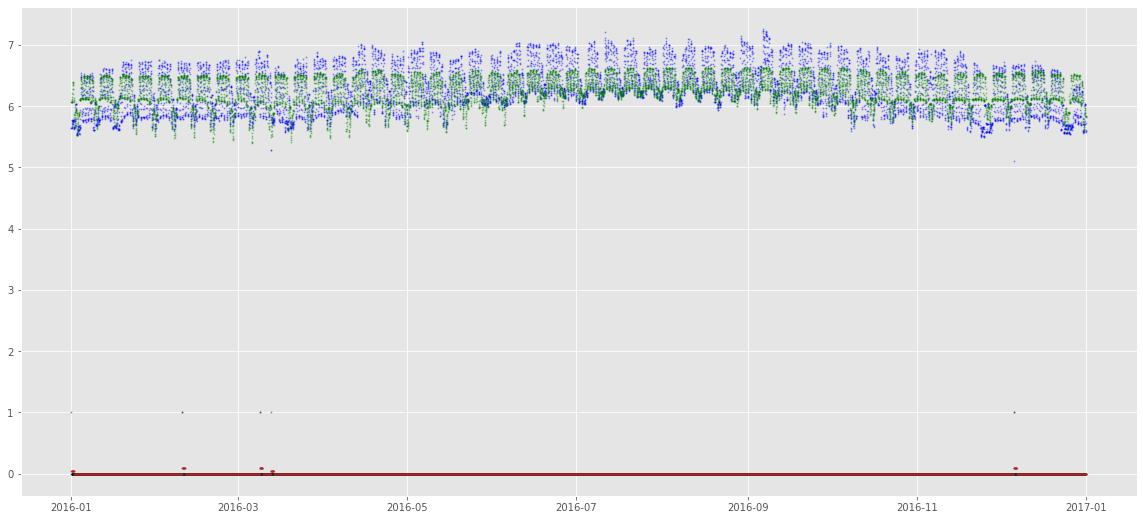

In [43]:
#ГРАФИК ПЛАН-ФАКТ
  plt.figure(figsize=(20,9))
  df['log1p_fact'] = np.log(1+df['meter_reading'])
  df['log1p_plan'] = np.log(1+df['NN_PRED'])
  met = 0
  building_id = 1099
  #1099, 106
  plt.plot( df[(df['meter']==met) & (df['building_id']==building_id)]['timestamp']
          , df[(df['meter']==met) & (df['building_id']==building_id)]['log1p_fact'] , 'ro', markersize = 1   , color = 'blue' ,label = 'Факт', alpha = 0.3)
  plt.plot( df[(df['meter']==met) & (df['building_id']==building_id)]['timestamp']
           , df[(df['meter']==met) & (df['building_id']==building_id)]['log1p_plan'] , 'ro', markersize = 1  , color = 'green',label = 'План', alpha = 0.3)
  plt.plot( df[(df['meter']==met) & (df['building_id']==building_id)]['timestamp']
           , df[(df['meter']==met) & (df['building_id']==building_id)]['is_equal_prev'] , 'ro', markersize = 1  , color = 'black',label = 'Выкинуто', alpha = 0.3)
  plt.plot( df[(df['meter']==met) & (df['building_id']==building_id)]['timestamp']
           , df[(df['meter']==met) & (df['building_id']==building_id)]['IS_BAD_PRCNT'] , 'ro', markersize = 1  , color = 'brown',label = 'Выкинуто', alpha = 0.3)
  plt.show()

In [0]:
#nn_3.save(DIR + str(meter) + 'HANDLY_SAVED.MODEL')
# keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)

-- -- -- -- -- -- -- -- -- Предсказание -- -- -- -- -- -- -- -- --

In [7]:
#Предсказание из 4х значений:
  nn_0 = keras.models.load_model (DIR_SAVE + '0HANDLY_SAVED3best.MODEL')
  nn_1 = keras.models.load_model (DIR_SAVE + '1HANDLY_SAVED3best.MODEL')
  nn_2 = keras.models.load_model (DIR_SAVE + '2HANDLY_SAVED3best.MODEL')
  nn_3 = keras.models.load_model (DIR_SAVE + '3HANDLY_SAVED3best.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  df.drop(columns = ['NN_PRED_0', 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'], inplace = True)
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)

  print( 'Ошибка общая: ', np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))
      , 'Ошибка (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  # print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )

  gc.collect()











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Ошибка общая:  1.201942101109258 Ошибка (VAL):  1.2157844345883388 Ошибка (VAL_чист):  0.5428777796861576 Ошибка (VAL_чист2):  0.44390349931201895
Ошибка 0:  1.0561839497027294 Ошибка 0 (VAL):  1.0494707718101652 Ошибка 0 (VAL_чист):  0.3156409636496557 Ошибка 0 (VAL_чист2):  0.2912136215873155
Ошибка 1:  1.378698116463559 Ошибка 1 (VAL):  1.4146369943673582 Ошибка 1 (VAL_чист):  0.7336364983846207 Ошибка 1 (VAL_чист2):  0.6205787875220308
Ошибка 2:  1.4120891287253647 Ошибка 2 (VAL):  1.4307337158934215 Ошибка 2 (VAL_чист):  0.7681072203556358 Ошибка 2 (VAL_чист2):  0.5899942296248842
Ошибка 3:  1.3779449168098614 Ошибка 3 (VAL):  1.4566577836916856 Ошибка 3 (VAL_чист):  1.093988479381104 Ошибка 3 (VAL_чист2):  0.7449017999477036


0

In [0]:
#Ошибки:
  Ошибка  :  1.2019422970227465 Ошибка (VAL):   1.2157846256813984 Ошибка (VAL_чист):   0.5428777256494879 Ошибка (VAL_чист2)  :  0.4439034380986012
  Ошибка 0:  1.0561841191435806 Ошибка 0 (VAL): 1.0494709359899506 Ошибка 0 (VAL_чист): 0.3156408787681845 Ошибка 0 (VAL_чист2):  0.2912135296204619
  Ошибка 1:  1.3786985710716286 Ошибка 1 (VAL): 1.4146374427353003 Ошибка 1 (VAL_чист): 0.7336364189822585 Ошибка 1 (VAL_чист2):  0.6205787113997202
  Ошибка 2:  1.412089120404965 Ошибка 2 (VAL):  1.4307337011199783 Ошибка 2 (VAL_чист): 0.7681072077180416 Ошибка 2 (VAL_чист2):  0.5899942163118871
  Ошибка 3:  1.377944923928185 Ошибка 3 (VAL):  1.4566577965681673 Ошибка 3 (VAL_чист): 1.0939884892538    Ошибка 3 (VAL_чист2):  0.7449018059731893
  0
  Общая:     1.2940425445438188 Ошибка (VAL):   1.3035619563953205 Ошибка (VAL_чист):   0.6154425269032927 Ошибка (VAL_чист2):    0.5166720488706185
  Ошибка 0:  1.1108272200417615 Ошибка 0 (VAL): 1.1039979542354519 Ошибка 0 (VAL_чист): 0.4199684887318391 Ошибка 0 (VAL_чист2):  0.40071672645920714
  Ошибка 1:  1.4674246744239359 Ошибка 1 (VAL): 1.4998371692364791 Ошибка 1 (VAL_чист): 0.7936248109822508 Ошибка 1 (VAL_чист2):  0.6763456453516548
  Ошибка 2:  1.584895359471045 Ошибка 2 (VAL):  1.595279682390636 Ошибка 2 (VAL_чист):  0.8156651059087789 Ошибка 2 (VAL_чист2):  0.6075341541971445
  Ошибка 3:  1.5811641937262615 Ошибка 3 (VAL):  1.6275882770258792 Ошибка 3 (VAL_чист):1.1791615642131834 Ошибка 3 (VAL_чист2):  0.8287557439810707
  0
  Общая  :   1.2383488513622485 Ошибка (VAL):   1.2497646476956246 Ошибка (VAL_чист):    0.5613541671314798 Ошибка (VAL_чист2):    0.4601055341524471
  Ошибка 0:  1.089517078219136 Ошибка 0 (VAL):  1.0830665788767133 Ошибка 0 (VAL_чист):  0.32307141312090654 Ошибка 0 (VAL_чист2): 0.2984998363948374
  Ошибка 1:  1.4093559595246432 Ошибка 1 (VAL): 1.4441371298998904 Ошибка 1 (VAL_чист):  0.7674735069465627 Ошибка 1 (VAL_чист2):  0.6515384132612695
  Ошибка 2:  1.434270799339943 Ошибка 2 (VAL):  1.4459949706379165 Ошибка 2 (VAL_чист):  0.7751574071879366 Ошибка 2 (VAL_чист2):  0.59349123776128
  Ошибка 3:  1.4481746111510552 Ошибка 3 (VAL): 1.5064615354375264 Ошибка 3 (VAL_чист):  1.0977130741767314 Ошибка 3 (VAL_чист2):  0.7436043422326556
  0
  Общая:     1.288451580726024 Ошибка (VAL):     1.2967080663610595 Ошибка (VAL_чист):    0.5559658155345275 Ошибка (VAL_чист2):   0.45027898146764
  Ошибка 0:  1.1135345769523262 Ошибка 0 (VAL):  1.1073602983520954 Ошибка 0 (VAL_чист):  0.30211474219652695 Ошибка 0 (VAL_чист2):0.2760929212947043
  Ошибка 1:  1.4447116762681158 Ошибка 1 (VAL):  1.4773486254929924 Ошибка 1 (VAL_чист):  0.778543934083951 Ошибка 1 (VAL_чист2):  0.6485716599103746
  Ошибка 2:  1.4827505038656164 Ошибка 2 (VAL):  1.4859210115055426 Ошибка 2 (VAL_чист):  0.776992332783179 Ошибка 2 (VAL_чист2):  0.5982294414393752
  Ошибка 3:  1.6852442156559078 Ошибка 3 (VAL):  1.7187446259260037 Ошибка 3 (VAL_чист):  1.0748931586686294 Ошибка 3 (VAL_чист2): 0.726536756006331
  0
  Общая:     1.3473874674637107 Ошибка (VAL):    1.3483415928656848 Ошибка (VAL_чист):    0.5756767405084868 Ошибка (VAL_чист2):   0.4623615327006715
  Ошибка 0:  1.097150680567493 Ошибка 0 (VAL):   1.0891511641164369 Ошибка 0 (VAL_чист):  0.33891800740903766 Ошибка 0 (VAL_чист2):0.3149225188104313
  Ошибка 1:  1.5319581086991891 Ошибка 1 (VAL):  1.5591904765901698 Ошибка 1 (VAL_чист):  0.7038461305727779 Ошибка 1 (VAL_чист2): 0.5850605730802025
  Ошибка 2:  1.6638633608261502 Ошибка 2 (VAL):  1.6575565750506658 Ошибка 2 (VAL_чист):  0.9184081840472923 Ошибка 2 (VAL_чист2): 0.6847327356541326
  Ошибка 3:  1.9625404814033556 Ошибка 3 (VAL):  1.955545484766667 Ошибка 3 (VAL_чист):   1.1170540079900018 Ошибка 3 (VAL_чист2): 0.7521327934769413

In [0]:
#тмп
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 100)
  warnings.filterwarnings('ignore')
  np.set_printoptions (precision = 4, suppress  = True)

  df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)
  print(len(df), len(df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['IS_BAD_PRCNT']<0.25)]))
  print(df[(df['hour']==14) & (df['meter']==0) & (df['building_id']==1) & (df['IS_BAD_PRCNT']<0.25)][['timestamp','hour','weekday','meter_reading','NN_PRED','NN_ERR','k_NN_ERR']].sort_values('timestamp').head(400))

In [0]:
df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50)  & (df['IS_BAD_PRCNT']<0.25)].describe()

In [0]:
print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )

1.3473874674637107




**-- -- -- -- -- -- -- -- --РАСЧЁТ НЕЙРОНОК после очистки -- -- -- -- -- -- -- -- --**



In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
# РАСЧЁТ НЕЙРОНОК:
  reg = 0.00001
  batch_size = 2048
  epochs = 30
  meter = 0

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  init = TruncatedNormal(mean=0.0, stddev=0.05, seed=159)
  bias = Constant(value = 0.1)
  
  if 0==0:
    meter = 0
    opt = Adam(lr = 0.001)

    nn_0 = Sequential()
    nn_0.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
    nn_0.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
    nn_0.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
    nn_0.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
    nn_0.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_0.compile(optimizer = opt, loss = MALE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    
    val = df[(df['meter'] == meter) & (df['day']%6 == 0) ]# & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100 & (df['IS_BAD_PRCNT'] < 0.25)]
    #val_2 = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.25)]
    df_cleared = df[(df['day']%6 != 0) & (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['meter'] == meter) & (df['IS_BAD_PRCNT'] < 0.45)][In_Columns + [Out_Columns]]

    hist = nn_0.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                    , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 
    nn_0.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED_3.MODEL')
    gc.collect()

In [0]:
for lr in [0.001]:
  opt = Adam(lr = lr)
  epochs = 20
  batch_size = 2048
  meter = 0
  nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED_3best.MODEL')
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.25)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['day']%6 != 0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns + [Out_Columns]]
  print('*'*9, lr, '*'*33)
  nn_0.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_0.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_0.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
#История ошибок:
    # 0 - 0.001 |  TST_loss: 0.4634 TST_MAE_: 0.2970 TST_RMSLE: 0.7195 TST_VAL_: 0.9428 TST_mean_squared_error: 95502.1200 TST_MAPE_: 0.5170 ///  TRN_loss: 0.2670 TRN_MAE_: 0.3262 TRN_RMSLE: 0.4111 TRN_VAL_: 0.7641 TRN_mean_squared_error: 60868.2692 TRN_MAPE_: 0.2894
    # Ошибка 0:  1.090040142661055  Ошибка 0 (VAL):  1.0821874168451948 Ошибка 0 (VAL_чист):  0.4200194527624282 Ошибка 0 (VAL_чист):  0.3982010565789388
    #-Ошибка 0:  1.0561841191435806 Ошибка 0 (VAL):  1.0494709359899506 Ошибка 0 (VAL_чист):  0.3156408787681845 Ошибка 0 (VAL_чист):  0.2912135296204619

    # 1 - 
    #Ошибка 1:  1.432671362118033 Ошибка 1 (VAL):  1.4735626469840335 Ошибка 1 (VAL_чист):  0.6584706237724794 Ошибка 1 (VAL_чист):  0.521774231818768
    #Ошибка 1:  1.434113723728525 Ошибка 1 (VAL):  1.4742295518711512 Ошибка 1 (VAL_чист):  0.665647741234266  Ошибка 1 (VAL_чист):  0.5298978788312768
      #Ошибка 1:  1.431368815234858  Ошибка 1 (VAL):  1.4686131222512504 Ошибка 1 (VAL_чист):  0.6759214072760591 Ошибка 1 (VAL_чист):  0.5449250862446658
      #Ошибка 1:  1.4691654987946658 Ошибка 1 (VAL):  1.5049969920282047 Ошибка 1 (VAL_чист):  0.6922470701866289 Ошибка 1 (VAL_чист):  0.5644578193999968
      #Ошибка 1:  1.485687076453129  Ошибка 1 (VAL):  1.5214040444045644 Ошибка 1 (VAL_чист):  0.6952623800744953 Ошибка 1 (VAL_чист):  0.5632174649208512
      #Ошибка 1:  1.4856709523394191 Ошибка 1 (VAL):  1.5205201826214512 Ошибка 1 (VAL_чист):  0.7050914102031174 Ошибка 1 (VAL_чист):  0.5759439648595509
      #Ошибка 1:  1.4859038202056085 Ошибка 1 (VAL):  1.519788443345392 Ошибка 1 (VAL_чист):  0.7140834358696859 Ошибка 1 (VAL_чист):  0.5869849079847015
    #-Ошибка 1:  1.3667812429174853 Ошибка 1 (VAL):  1.4029945499659757 Ошибка 1 (VAL_чист):  0.7281895570502563 Ошибка 1 (VAL_чист):  0.6149901419154421

    # 2 - 
    #Ошибка 2:  1.468362770102303  Ошибка 2 (VAL):  1.4851731624800186 Ошибка 2 (VAL_чист):  0.8590320764392491 Ошибка 2 (VAL_чист):  0.6062495965271513
      #Ошибка 2:  1.4611062782548563 Ошибка 2 (VAL):  1.4752267752422543 Ошибка 2 (VAL_чист):  0.8709034145221702 Ошибка 2 (VAL_чист):  0.6277950102050106
      #Ошибка 2:  1.5130303989486868 Ошибка 2 (VAL):  1.5254828603596124 Ошибка 2 (VAL_чист):  0.8949163247727348 Ошибка 2 (VAL_чист):  0.6479195418249479
    #-Ошибка 2:  1.412089120404965 Ошибка 2 (VAL):  1.4307337011199783 Ошибка 2 (VAL_чист):  0.7681072077180416 Ошибка 2 (VAL_чист):  0.5899942163118871

    #3 - 
    #Ошибка 3:  1.42819615426734 Ошибка 3 (VAL):  1.512136946020539  Ошибка 3 (VAL_чист):  1.191953830076372  Ошибка 3 (VAL_чист):  0.7587751529627325
    #Ошибка 3:  1.42971650236124 Ошибка 3 (VAL):  1.5122676972866884 Ошибка 3 (VAL_чист):  1.1904067684130355 Ошибка 3 (VAL_чист):  0.7592933381085122
      #Ошибка 3:  1.418658013012662  Ошибка 3 (VAL):  1.489236064645708  Ошибка 3 (VAL_чист):  1.196464556606421 Ошибка 3 (VAL_чист):  0.7835597310779343
      #Ошибка 3:  1.4462524866377109 Ошибка 3 (VAL):  1.5214038274048738 Ошибка 3 (VAL_чист):  1.192125464837195 Ошибка 3 (VAL_чист):  0.7625560621553749
      #Ошибка 3:  1.4495662773326137 Ошибка 3 (VAL):  1.5192560445361858 Ошибка 3 (VAL_чист):  1.196845847794619 Ошибка 3 (VAL_чист):  0.7829511528840523
    #-Ошибка 3:  1.377944923928185  Ошибка 3 (VAL):  1.4566577965681673 Ошибка 3 (VAL_чист):  1.0939884892538    Ошибка 3 (VAL_чист):  0.7449018059731893


In [18]:
#Предсказание из 4х значений = 0:
  meter = 3
  nn_tmp = keras.models.load_model (DIR_SAVE + str(meter) + 'HANDLY_SAVED_3.MODEL')
  
  gc.collect()
  col_name_tmp = 'NN_PRED_'+str(meter) 
  df['NN_PRED'] = 0.0000
  bad_pcnt = 0.45
  k_err = 50
  df[col_name_tmp] = nn_tmp.predict(df[In_Columns], batch_size = 400000) 
  df['NN_PRED'] = np.where(df['meter'] == meter, df[col_name_tmp], df['NN_PRED'])
  df.drop(columns = [col_name_tmp], inplace = True) #, 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  #df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)

  #print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )
  print('Ошибка ' + str(meter) + ': '  , np.sqrt( np.mean( np.power(np.log(df[df['meter']==meter]['meter_reading']+1) - np.log(df[df['meter']==meter]['NN_PRED']+1),2.00000)))        
      , 'Ошибка ' + str(meter) + ' (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==meter) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==meter) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка ' + str(meter) + ' (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < bad_pcnt) & (df['meter']==meter) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < bad_pcnt) & (df['meter']==meter) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка ' + str(meter) + ' (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < k_err) & (df['k_NN_ERR'] > 1/k_err) & (df['IS_BAD_PRCNT'] < bad_pcnt) & (df['meter']==meter) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < k_err) & (df['k_NN_ERR'] > 1/k_err) & (df['IS_BAD_PRCNT'] < bad_pcnt) & (df['meter']==meter) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  gc.collect()

Ошибка 3:  1.4600607439127282 Ошибка 3 (VAL):  1.5321936733863368 Ошибка 3 (VAL_чист):  1.216362083563116 Ошибка 3 (VAL_чист):  0.7869769672040327


0

In [0]:
nn_tmp.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED_3best.MODEL')

In [16]:
# Дообучение!
  meter = 3
  nn_tmp = keras.models.load_model (DIR_SAVE + str(meter) + 'HANDLY_SAVED_3best.MODEL')
  
  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_delta=1e-4, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  bad_pcnt = 0.75
  k_err = 50
  epochs = 30
  batch_size = 256

  val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < bad_pcnt ) ]
  tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < bad_pcnt ) & (df['k_NN_ERR'] < k_err) & (df['k_NN_ERR'] > 1/k_err) & (df['meter'] == meter) ]

  print('Длина трейн ',len(tar), 'длина валидации ',len(val), 'сфильтровано:'
  , len(df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < bad_pcnt ) & (df['k_NN_ERR'] > k_err)  ]) + len(df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < bad_pcnt ) & (df['k_NN_ERR'] < 1/k_err)  ]))  
  
  for lr in [0.0002]: #,0.001]:
    for los in [ MALE ]: # mse, MALE, RMSLE, MAE_, RMSLE ]:
      print(los, lr)
      opt = Adam(lr = lr)

      print('*'*9, lr, '*'*33)
      nn_tmp.compile(optimizer = opt, loss = los, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
      hist = nn_tmp.fit( tar[In_Columns], tar[Out_Columns], batch_size = batch_size, verbose = 0
                      , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                      , validation_data=(val[In_Columns], val[Out_Columns])
                    )
      
      nn_tmp.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED_3.MODEL')
  del val, tar
  gc.collect()

Длина трейн  760164 длина валидации  155614 сфильтровано: 17097
<function MALE at 0x7f83d41e9e18> 0.0002
********* 0.0002 *********************************
# 0001 |  TST_loss: 0.6484 TST_MAE_: 0.3687 TST_RMSLE: 1.0162 TST_VAL_: 0.9070 TST_mean_squared_error: 5233772.6106 TST_MAPE_: 0.7657 ///  TRN_loss: 0.4664 TRN_MAE_: 0.3808 TRN_RMSLE: 0.7276 TRN_VAL_: 0.8662 TRN_mean_squared_error: 3865405.4633 TRN_MAPE_: 0.6569
# 0002 |  TST_loss: 0.6422 TST_MAE_: 0.3659 TST_RMSLE: 1.0139 TST_VAL_: 0.9326 TST_mean_squared_error: 5142177.7042 TST_MAPE_: 0.7652 ///  TRN_loss: 0.4630 TRN_MAE_: 0.3784 TRN_RMSLE: 0.7381 TRN_VAL_: 0.8738 TRN_mean_squared_error: 3790369.1732 TRN_MAPE_: 0.6476
# 0003 |  TST_loss: 0.6428 TST_MAE_: 0.3694 TST_RMSLE: 1.0186 TST_VAL_: 0.9527 TST_mean_squared_error: 5212913.4214 TST_MAPE_: 0.7725 ///  TRN_loss: 0.4614 TRN_MAE_: 0.3779 TRN_RMSLE: 0.7425 TRN_VAL_: 0.8677 TRN_mean_squared_error: 3843195.9611 TRN_MAPE_: 0.6435
.......
# 0004 |  TST_loss: 0.6416 TST_MAE_: 0.3677 TST

216

In [0]:
print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  

Ошибка 0:  1.0967505629134169 Ошибка 0 (VAL):  1.0889958705909204 Ошибка 0 (VAL_чист):  0.29653998158216416


In [0]:
if 1==1:
  reg = 0.00001
  meter = 1
  epochs = 190
  batch_size = 1024
  opt = Adam(lr = 0.001)
  bias = Constant(value = 0.1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=15, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_1 = Sequential()
  nn_1.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
  nn_1.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_1.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

  nn_1.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.25)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['day']%6 != 0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns + [Out_Columns]]

  hist = nn_1.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
for lr in [0.007]:
  opt = Adam(lr = lr)
  epochs = 70
  meter = 1
  batch_size = 720

  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['day']%6 != 0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]

  print('*'*9, lr, '*'*33)
  nn_1.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_1.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
#Предсказание из 4х значений = 0:
  #nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED_3.MODEL')
  nn_1 = keras.models.load_model (DIR + '1HANDLY_SAVED_3.MODEL')
  #nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED_3.MODEL')
  #nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED_3.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  #df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  #df.drop(columns = ['NN_PRED_0'], inplace = True) #, 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )
  # print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
  # , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  # , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  # , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  
  #print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )
  #df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)
  gc.collect()

4.143660029954269
Ошибка 0:  1.4462519064009887 Ошибка 0 (VAL):  1.4819992377016542 Ошибка 0 (VAL_чист):  0.628029160200588 Ошибка 0 (VAL_чист):  0.4921451933316616


0

In [0]:
Ошибка 0:  1.4622222874555681 Ошибка 0 (VAL):  1.4974377063554198 Ошибка 0 (VAL_чист):  0.6416758062352609 Ошибка 0 (VAL_чист):  0.5087780382284447
Ошибка 0:  1.4513305175601738 Ошибка 0 (VAL):  1.4857607748364132 Ошибка 0 (VAL_чист):  0.6544772099268412 Ошибка 0 (VAL_чист):  0.5241878970208895
Ошибка 0:  1.559959814457174 Ошибка 0 (VAL):  1.5880652782130562 Ошибка 0 (VAL_чист):  0.6931055197830647 Ошибка 0 (VAL_чист):  0.5696662087687516
Ошибка 1:  1.5319581160458586 Ошибка 1 (VAL):  1.5591904792676097 Ошибка 1 (VAL_чист):  0.7038461338617784 Ошибка 1 (VAL_чист2):  0.5850605758832433

In [0]:
if 2==2:
  reg = 0.00002
  meter = 2
  epochs = 30
  batch_size = 2400
  opt = Adam(lr = 0.003)
  bias = Constant(value = 5.7)

  earlyStopping = EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=12, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_2 = Sequential()
  nn_2.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'uniform', kernel_regularizer=l2(reg), bias_initializer=bias))
  nn_2.add(Dense(100, activation = 'tanh',  kernel_initializer = 'uniform', bias_initializer=bias))
  nn_2.add(Dense(100, activation = 'tanh',  kernel_initializer = 'uniform', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_2.add(Dense(100, activation = 'tanh',  kernel_initializer = 'uniform', bias_initializer=bias))
  nn_2.add(Dense( 1, activation = 'relu', kernel_initializer = 'normal'))

  nn_2.compile(optimizer = opt, loss = MAE_RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.75)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.75)][In_Columns + [Out_Columns]]
  print (len(df_cleared), len(val))

  hist = nn_2.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_2.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
for lr in [0.03]:
  nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED_3best.MODEL')
  opt = Adam(lr = lr)
  epochs = 70
  batch_size = 700
  meter = 2
  bias = Constant(value = 0.1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=15, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['day']%6 != 0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]
  print('*'*9, lr, '*'*33)
  nn_0.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_2.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_2.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [19]:
if 3==3:
  meter = 3
  epochs = 7
  batch_size = 256
  opt = Adam(lr = 0.007)
  reg = 0.0002
  bias = Constant(value = 5.7)

  earlyStopping = EarlyStopping(monitor='loss', patience=50, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1, min_delta=2e-4, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_3 = Sequential()
  nn_3.add(Dense(30, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
  nn_3.add(Dense(45, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dropout(0.01, noise_shape=None, seed=None) )
  nn_3.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_3.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

  nn_3.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.75)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50)  & (df['day']%6!=0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.75)][In_Columns + [Out_Columns]]

  hist = nn_3.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

NameError: ignored

In [0]:
for lr in [0.007]:
  opt = Adam(lr = lr)
  epochs = 200
  batch_size = 700
  meter = 3
  nn_3 = keras.models.load_model (DIR + str(meter) + 'HANDLY_SAVED_3best.MODEL')

  earlyStopping = EarlyStopping(monitor='loss', patience=50, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=12, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['day']%6 != 0) & (df['k_NN_ERR']>1/50) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]
  print('*'*9, lr, '*'*33)
  nn_3.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_3.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
#nn_0.save(DIR + '0HANDLY_SAVED_3best.MODEL')
  # nn_1.save(DIR + '1HANDLY_SAVED_3best.MODEL')
  # nn_2.save(DIR + '2HANDLY_SAVED_3best.MODEL')
  # nn_3.save(DIR + '3HANDLY_SAVED_3best.MODEL')

In [0]:
#Предсказание из 4х значений:
  nn_0 = keras.models.load_model (DIR_SAVE + '0HANDLY_SAVED_3best.MODEL')
  nn_1 = keras.models.load_model (DIR_SAVE + '1HANDLY_SAVED_3best.MODEL')
  nn_2 = keras.models.load_model (DIR_SAVE + '2HANDLY_SAVED_3best.MODEL')
  nn_3 = keras.models.load_model (DIR_SAVE + '3HANDLY_SAVED_3best.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  df.drop(columns = ['NN_PRED_0', 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'], inplace = True)
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)

  print( 'Ошибка общая: ', np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))
      , 'Ошибка (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  # print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )

  gc.collect()

In [0]:
#Ошибки:
  Ошибка общая:  1.3332699709812266 Ошибка (VAL):  1.337540194067479 Ошибка (VAL_чист):  0.5418592287241801 Ошибка (VAL_чист2):  0.40073096858305257
  Ошибка 0:  1.098206407152078 Ошибка 0 (VAL):  1.0905813857988798 Ошибка 0 (VAL_чист):  0.28240200416498673 Ошибка 0 (VAL_чист2):  0.2562246375809472
  Ошибка 1:  1.4462519064009887 Ошибка 1 (VAL):  1.4819992377016542 Ошибка 1 (VAL_чист):  0.628029160200588 Ошибка 1 (VAL_чист2):  0.47946068818401355
  Ошибка 2:  1.6966445281141582 Ошибка 2 (VAL):  1.6978240187666451 Ошибка 2 (VAL_чист):  0.926254557141954 Ошибка 2 (VAL_чист2):  0.6472006361307439
  Ошибка 3:  1.9577298686058777 Ошибка 3 (VAL):  1.9537862377808086 Ошибка 3 (VAL_чист):  1.1455655044777464 Ошибка 3 (VAL_чист2):  0.6972188121146171

  Ошибка общая:  1.3473873510158345 Ошибка (VAL):  1.3483414756663568 Ошибка (VAL_чист):  0.5756767186919248 Ошибка (VAL_чист2):  0.462361504102313
  Ошибка 0:  1.0971504229404558 Ошибка 0 (VAL):  1.0891509074774033 Ошибка 0 (VAL_чист):  0.3389179667173395 Ошибка 0 (VAL_чист2):  0.3149224768996143
  Ошибка 1:  1.5319581160458586 Ошибка 1 (VAL):  1.5591904792676097 Ошибка 1 (VAL_чист):  0.7038461338617784 Ошибка 1 (VAL_чист2):  0.5850605758832433
  Ошибка 2:  1.6638634087676607 Ошибка 2 (VAL):  1.6575566177087862 Ошибка 2 (VAL_чист):  0.918408148629441 Ошибка 2 (VAL_чист2):  0.6847326774214916
  Ошибка 3:  1.9625404709477796 Ошибка 3 (VAL):  1.9555454713909437 Ошибка 3 (VAL_чист):  1.117054007408267 Ошибка 3 (VAL_чист2):  0.7521327942946583

In [0]:
#Evaluate:
  score = nn_0.evaluate(df[df['meter']==0][In_Columns], df[df['meter']==0][Out_Columns], verbose=1, batch_size = 30000)
  print(0)
  for i in range(len(nn_0.metrics_names)):
    print("%s: %.2f%%" % (nn_0.metrics_names[i], score[i]*100))

  score = nn_1.evaluate(df[df['meter']==1][In_Columns], df[df['meter']==1][Out_Columns], verbose=1, batch_size = 30000)
  print(1)
  for i in range(len(nn_1.metrics_names)):
    print("%s: %.2f%%" % (nn_1.metrics_names[i], score[i]*100))

  score = nn_2.evaluate(df[df['meter']==2][In_Columns], df[df['meter']==2][Out_Columns], verbose=1, batch_size = 30000)
  print(2)
  for i in range(len(nn_2.metrics_names)):
    print("%s: %.2f%%" % (nn_2.metrics_names[i], score[i]*100))

  score = nn_3.evaluate(df[df['meter']==3][In_Columns], df[df['meter']==3][Out_Columns], verbose=1, batch_size = 30000)
  print(3)
  for i in range(len(nn_3.metrics_names)):
    print("%s: %.2f%%" % (nn_3.metrics_names[i], score[i]*100))
  
  gc.collect()

In [0]:
#Важность показателей 0
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR_SAVE + '0HANDLY_SAVED3best.MODEL')
  meter = 0
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.45)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.set_option('display.float_format', lambda x: '%.4f' % x)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

                                 loss    MAE_   RMSLE    VAL_  mean_squared_error   MAPE_
name                                                                                     
building_meter_weekday_median  2.9106  0.9289  1.3989  0.0326         114978.4964  1.4665
square_feet                    0.4069  0.1125  0.3822  0.0089           7386.0101  0.3386
---INITIAL---                  0.1303  0.1884  0.3410  0.9108          25827.2513  0.2326
site_id                        0.2229  0.0807  0.2424  0.0108           3550.1542  0.2189
primary_use_ID                 0.1589  0.0633  0.1832  0.0067           3364.4379  0.1621
building_meter_hour_median     0.0844  0.0159  0.1069  0.0043            385.0823  0.1368
hour_cos                       0.0713  0.0415  0.0908  0.0012           1410.0715  0.0857
week_cos                       0.0378  0.0193  0.0521 -0.0163           1017.2717  0.0297
week_sin                       0.0370  0.0178  0.0513 -0.0100            857.0364  0.0294
air_temper

In [0]:
#Важность показателей 1
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR_SAVE + '1HANDLY_SAVED3.MODEL')
  meter = 1
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.25)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.set_option('display.float_format', lambda x: '%.4f' % x)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

In [0]:
#Важность показателей 2
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR_SAVE + '2HANDLY_SAVED3.MODEL')
  meter = 2
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.25)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.set_option('display.float_format', lambda x: '%.4f' % x)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

In [0]:
#Важность показателей 3
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR_SAVE + '3HANDLY_SAVED03.MODEL')
  meter = 3
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.25)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.set_option('display.float_format', lambda x: '%.4f' % x)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

In [0]:
ИДЕИ:
  1) Сделать не показатель, а его отклонение от медианы по строению/дню/часу
  2) 

In [0]:
#reduce_mem_usage(df_test)
gc.collect()
#df_test.describe()

0

In [0]:
# Подготовка данных тест:
  df_test = pd.read_csv(DIR + "test.csv", engine = 'python')
  print('Забрали с диска')
  df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

  df_test['hour_cos'] = np.cos(df_test['timestamp'].dt.hour * 2. * np.pi / 24.)
  df_test['hour_sin'] = np.sin(df_test['timestamp'].dt.hour * 2. * np.pi / 24.)

  df_test['weekday_cos'] = np.cos(df_test['timestamp'].dt.weekday * 2. * np.pi / 7.)
  df_test['weekday_sin'] = np.sin(df_test['timestamp'].dt.weekday * 2. * np.pi / 7.)

  df_test['week_cos'] = np.cos(df_test['timestamp'].dt.week * 2. * np.pi / 53.)
  df_test['week_sin'] = np.sin(df_test['timestamp'].dt.week * 2. * np.pi / 53.)

  #reduce_mem_usage(df_test)
  gc.collect()

Забрали с диска


91

In [0]:
# Добавление медиан:
  # Добавление медианы по метрике постройки
    df_median = df.groupby(by=['building_id','meter'])['building_meter_median'].median()
    df_test = pd.merge(df_test, df_median, how = 'left', on = ['building_id','meter'])
    del df_median 
    gc.collect()
    print('Построены медианы по сооружению')
  # Добавление медианы по часу, по неделе, метрике постройки
    df_test['hour'] = df_test['timestamp'].dt.hour
    df_median = df.groupby(by=['building_id','hour','meter'])['building_meter_hour_median'].median()
    df_test = pd.merge(df_test, df_median, how = 'left', on = ['building_id','hour','meter'])
    #print(len(df_test))
    del df_median #, df_mean, df_median2, df_mean2
    gc.collect()
    
    df_test['weekday'] = df_test['timestamp'].dt.weekday
    df_median = df.groupby(by=['building_id','weekday','meter'])['building_meter_weekday_median'].median()
    #df_median.name = 'building_meter_weekday_median'
    df_test = pd.merge(df_test, df_median, how = 'left', on = ['building_id','weekday','meter'])
    del df_median 
    #print(len(df_test))

    print('Построены медианы по сооружению/часу')
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                      "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                      "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                      "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                      "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                      "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                      "2019-01-01"]
    df_test["is_holiday"] = (df_test.timestamp.isin(holidays)).astype(int)
    del holidays
    gc.collect()
    #print(len(df_test))
  # Подстановка параметров сооружения
    df_median = df.groupby(by=['building_id'])['primary_use_ID','site_id','square_feet'].median()
    df_test = pd.merge(df_test, df_median, how = 'left', on = ['building_id'])
    del df_median 

    print('Подставлены данные по сооружению')
    gc.collect()
    #print(len(df_test))

Построены медианы по сооружению
Построены медианы по сооружению/часу
Подставлены данные по сооружению


0

In [0]:
del df
gc.collect()

0

In [0]:
#Вставка данных погоды
#Восстановление пустых данных погоды через соседей по линейной инетрполяции
  df_weather = pd.read_csv(DIR + "weather_test.csv", engine = 'python')
  df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
  df_weather.drop(columns = ['precip_depth_1_hr'], inplace = True)
  gc.collect()

  #weather_train.groupby('site_id').apply(lambda group: group.isna().sum())
  df_times = df_test.drop_duplicates(['site_id','timestamp'])[['site_id','timestamp']]
  df_times = pd.merge(df_times, df_weather, how = 'left', on = ['site_id','timestamp'])
  df_times.sort_values(by = ['site_id','timestamp'], inplace = True)
  gc.collect()

  df_times = df_times.groupby('site_id'  ).apply(lambda group: group.interpolate(limit_direction='both'))
  df_times = df_times.groupby('timestamp').apply(lambda group: group.interpolate(limit_direction='both'))
  
  df_test = pd.merge(df_test, df_times, how = 'left', on = ['site_id','timestamp'])
  del df_weather, df_times

  #del df_weather

In [0]:
#reduce_mem_usage(df_test)
df_test.to_feather(DIR_SAVE + 'DF_TEST_REDUCED3.FTHR')
gc.collect()

0

In [0]:
# Загрузка данных:
  #df_test = pd.read_feather(DIR_SAVE + 'DF_TEST_REDUCED3.FTHR')
  #gc.collect()
  import pickle
  with open(DIR_SAVE+'scaler31.pickle', 'rb') as handle:
      scaler = pickle.load(handle)
      In_Columns = pickle.load(handle)
      Out_Columns = pickle.load(handle)

In [0]:
# Нормализация
  i=0
  #print(scaler.data_max_)
  for c in In_Columns:
    if c in ['building_meter_median','building_meter_hour_median','building_meter_weekday_median','primary_use_ID','site_id','square_feet']:
      print(i, c, 'Уже нормализовано:', scaler.scale_[i],scaler.min_[i], '     ',scaler.data_min_[i], scaler.data_max_[i])
    else:
      print(i, c, scaler.scale_[i],scaler.min_[i], '     ', scaler.data_min_[i], scaler.data_max_[i])
      df_test[c] = df_test[c] * scaler.scale_[i] + scaler.min_[i]
    i+=1
    gc.collect()

In [0]:
# Выбор нейронок и предсказание:
  nn_0 = keras.models.load_model (DIR_SAVE + '0HANDLY_SAVED3best.MODEL')
  nn_1 = keras.models.load_model (DIR_SAVE + '1HANDLY_SAVED3best.MODEL')
  nn_2 = keras.models.load_model (DIR_SAVE + '2HANDLY_SAVED3best.MODEL')
  nn_3 = keras.models.load_model (DIR_SAVE + '3HANDLY_SAVED3best.MODEL')
  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()
  #Предсказание из 4х значений:
  if 1==1:
    df_test['NN_PRED'] = 0 
    df_test['NN_PRED']  = df_test['NN_PRED'].astype('float32')
    l = len(df_test)
    print( len(df_test) )
    step = 1600000
    for i in range(int(l/step)+1):
      print(i*step, (i+1)*step)
      tmp = df_test[i*step: (i+1)*step][In_Columns + ['row_id','meter']]
      gc.collect() 
      tmp['NN_PRED'] = 0 
      tmp['NN_PRED_0'] = nn_0.predict(tmp[In_Columns], batch_size = 20000) 
      tmp['NN_PRED_1'] = nn_1.predict(tmp[In_Columns], batch_size = 20000) 
      tmp['NN_PRED_2'] = nn_2.predict(tmp[In_Columns], batch_size = 20000) 
      tmp['NN_PRED_3'] = nn_3.predict(tmp[In_Columns], batch_size = 20000) 
      gc.collect()
      tmp['NN_PRED'] = np.where(tmp['meter'] == 0, tmp['NN_PRED_0'], tmp['NN_PRED'])
      tmp['NN_PRED'] = np.where(tmp['meter'] == 1, tmp['NN_PRED_1'], tmp['NN_PRED'])
      tmp['NN_PRED'] = np.where(tmp['meter'] == 2, tmp['NN_PRED_2'], tmp['NN_PRED'])
      tmp['NN_PRED'] = np.where(tmp['meter'] == 3, tmp['NN_PRED_3'], tmp['NN_PRED'])
      gc.collect()
      #print('спрогнозили')
      #df_test[i*step: (i+1)*step]['NN_PRED'] = pd.merge(df_test, tmp[['row_id','NN_PRED']], how = 'left', on = ['row_id'])
      #df_test.loc[i*step: (i+1)*step, 'NN_PRED'] = tmp['NN_PRED']
      
      if i==0:
        a = tmp[['row_id','NN_PRED', 'meter']].copy()
      else:
        a = pd.concat([a, tmp[['row_id','NN_PRED', 'meter']].copy()], sort=False)
      #del tmp
      #gc.collect() 

In [0]:
print(len(df_test))

41697600


In [0]:
a['row_id']         = a['row_id'].astype('Int32')
a['meter_reading']  = a['NN_PRED'].astype('float32')
a[['row_id', 'meter_reading']].to_csv(DIR_SAVE+'OUT_Ver0.31 no clean_6.csv', index = False)

In [0]:
a.head(-1)

,row_id,NN_PRED,meter,meter_reading
0,0,252.3435,0,252.3435
1,1,138.7939,0,138.7939
2,2,21.5660,0,21.5660
3,3,346.3572,0,346.3572
4,4,962.0777,0,962.0777
...,...,...,...,...
41697594,41697594,115.1817,0,115.1817
41697595,41697595,25.0976,0,25.0976
41697596,41697596,24.4483,0,24.4483
41697597,41697597,20.8425,0,20.8425


In [0]:
a.groupby(['meter'])['NN_PRED'].agg(['mean','median', 'min', 'max'])

,mean,median,min,max
meter,,,,
0,159.116,68.534,0.000,1355.983
1,352.780,116.053,0.000,2035.047
2,12714.100,237.592,0.000,17835566.000
3,219.173,32.681,0.000,32506.373


In [0]:
df.groupby(['meter'])['meter_reading'].agg(['mean','median', 'min', 'max'])

,mean,median,min,max
meter,,,,
0,162.707,68.000,0.000,79769.000
1,633.801,120.698,0.000,880374.000
2,14402.644,253.150,0.000,21904700.000
3,374.154,38.099,0.000,160187.000


In [0]:
df.groupby(['meter'])['NN_PRED'].agg(['mean','median', 'min', 'max'])

,mean,median,min,max
meter,,,,
0,158.798,74.755,0.000,1289.670
1,378.482,138.774,0.000,2033.057
2,11507.809,244.696,0.000,17275218.000
3,269.547,40.498,0.000,45745.234


In [0]:
df.describe()
air_temperature
is_holiday
cloud_coverage
dew_temperature
sea_level_pressure	
wind_direction	
wind_speed

,building_id,meter,meter_reading,hour_cos,hour_sin,weekday_cos,weekday_sin,week_cos,week_sin,meter_reading_prev,is_equal_prev,day,IS_BAD_PRCNT,building_meter_median,building_meter_mean,building_meter_mean_45,hour,building_meter_hour_median,building_meter_hour_mean,k_fact_med_hour,weekday,building_meter_weekday_median,is_holiday,site_id,square_feet,year_built,floor_count,primary_use_ID,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948183.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18293583.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,6974756.000,2358476.000,18948184.000,18948184.000,18948184.000,18948184.000,18078918.000,18948184.000,18948184.000,18948184.000
mean,801.974,0.676,2232.996,0.500,0.500,0.472,0.498,0.488,0.493,2232.996,0.161,185.601,0.161,0.001,2232.996,2575.451,11.502,0.001,2232.996,23368.884,3.007,0.009,0.001,0.541,0.121,1969.248,4.052,0.220,0.595,0.316,0.685,0.984,0.620,0.470,0.175
std,440.083,0.934,158278.578,0.354,0.354,0.372,0.363,0.352,0.355,158278.582,0.367,105.237,0.314,0.022,82117.057,85395.660,6.922,0.024,82265.539,1023290.661,1.997,0.039,0.034,0.348,0.127,31.279,3.071,0.231,0.144,0.306,0.178,7.683,0.091,0.314,0.118
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1900.000,1.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000
25%,357.000,0.000,20.707,0.146,0.146,0.000,0.099,0.140,0.131,20.707,0.000,97.000,0.000,0.000,38.634,47.025,6.000,0.000,35.973,1.083,1.000,0.001,0.000,0.200,0.038,1951.000,1.000,0.000,0.497,0.000,0.548,0.000,0.563,0.194,0.111
50%,918.000,0.000,83.000,0.500,0.500,0.357,0.500,0.455,0.470,83.000,0.000,186.000,0.000,0.000,109.848,127.470,12.000,0.000,107.921,1.274,3.000,0.002,0.000,0.600,0.083,1970.000,4.000,0.200,0.606,0.222,0.702,0.000,0.620,0.472,0.163
75%,1200.000,1.000,272.860,0.854,0.854,0.802,0.901,0.837,0.848,272.860,0.000,277.000,0.125,0.001,307.502,358.264,18.000,0.001,305.962,1.978,5.000,0.006,0.000,0.867,0.157,1999.000,6.000,0.400,0.700,0.500,0.827,0.000,0.675,0.750,0.242
max,1448.000,3.000,21904700.000,1.000,1.000,1.000,1.000,1.000,1.000,21904700.000,1.000,366.000,1.000,1.000,3813882.148,3866686.396,23.000,1.000,4138801.770,57329462.143,6.000,1.000,1.000,1.000,1.000,2017.000,16.000,1.000,1.000,1.000,1.000,343.000,1.000,1.000,1.000


In [0]:
df_test.describe()

,row_id,building_id,meter,hour_cos,hour_sin,weekday_cos,weekday_sin,week_cos,week_sin,building_meter_median,hour,building_meter_hour_median,weekday,building_meter_weekday_median,is_holiday,primary_use_ID,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed,NN_PRED
count,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000
mean,20848799.5000,807.5824,0.6643,0.5000,0.5000,0.4751,0.4995,0.4913,0.5000,0.0013,11.5000,0.0014,3.0000,0.0088,0.0001,0.2105,0.5391,0.1219,-0.0003,0.1318,12.2029,13.7401,19.5723,0.6340,0.0000
std,12037060.4366,429.7680,0.9278,0.3536,0.3536,0.3722,0.3625,0.3508,0.3566,0.0215,6.9222,0.0236,2.0034,0.0375,0.0023,0.2301,0.3423,0.1327,0.0000,0.1338,6.3944,0.0915,9.9943,0.0308,0.0000
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0003,0.0000,-10.6000,13.1524,0.0000,0.5728,0.0000
25%,10424399.7500,404.7500,0.0000,0.1464,0.1464,0.0000,0.0990,0.1405,0.1516,0.0001,5.7500,0.0001,1.0000,0.0005,0.0000,0.0000,0.2000,0.0365,-0.0003,0.0178,7.6000,13.6999,11.2593,0.6131,0.0000
50%,20848799.5000,900.0000,0.0000,0.5000,0.5000,0.3569,0.5000,0.5144,0.5000,0.0002,11.5000,0.0002,3.0000,0.0020,0.0000,0.0667,0.6000,0.0823,-0.0003,0.0978,12.4000,13.7472,20.2222,0.6307,0.0000
75%,31273199.2500,1194.2500,1.0000,0.8536,0.8536,0.8019,0.9010,0.8373,0.8484,0.0006,17.2500,0.0006,5.0000,0.0061,0.0000,0.4000,0.8667,0.1579,-0.0003,0.2133,17.0667,13.7922,27.4074,0.6514,0.0000
max,41697599.0000,1448.0000,3.0000,1.0000,1.0000,1.0000,1.0000,0.9965,1.0000,1.0000,23.0000,1.0000,6.0000,1.0000,0.0667,1.0000,1.0000,1.0000,-0.0003,0.6000,26.7000,14.0407,40.0000,0.9689,0.0000


In [0]:
show_plot(hist) 

In [0]:
nn = load_model(DIR, 'model_nn')
opt = Adam(lr = 0.05)
nn.compile(optimizer = opt, loss = mse)
